# Heart Disease Classification using Cleveland Dataset

This notebook applies traditional machine learning approach to Cleveland Heart dataset for classifying heart disease.





**The steps performed on the notebook is as follows:** The steps include reducing the number of features (columns) based on correlation of the feature with the label column.

1) To clean the data, remove the rows that have missing information on columns ca and thal.

2) Converted all fields to numeric data types

3) Analyzed the **correlations** between the fields and the label and then dropped 4 fields ('chol', 'fbs', 'trestbps', 'restecg’) that has correlation less than 0.2

4) Scaled the data

5) Calculated cross validation (k=5) accuracy scores for 10 different machine learning algorithms:

- Stochastic Gradient Descent (SGD)
- LogisticRegression
- Support Vector Machine (kernel='linear' parameter)
- Support Vector Machine (kernel = 'rbf' parameter)
- DecisionTreeClassifier
- RandomForestClassifier
- ExtraTreesClassifier
- AdaBoostClassifier
- GradientBoostingClassifier
- XGBoost


6) Identified top-performing algorithms (adaboost, random forest, gradient boosting, XGB) that can be fine-tuned by adjusting hyperparameters. Improved accuracy scores by performing Grid Search with the following hyperparameters:

- n_estimators = [100, 200, 300, 400, 500]
- learning_rate = [0.3, 0.1, 0.05]
- max_features = [1, 0.7, 0.5, 0.4, 0.3]
- subsample = [1, 0.5, 0.3]
- max_samples = [1, 0.5, 0.3, 0.2]
- bootstrap = [True,False]

7) Using the fine-tuned estimators (adaboost, random forest, gradient boosting, XGB) and top-performing other estimators (SVC, SGD, Logistic regression), formed an ensemble voting classifier.






#### Import the data and perform exploratory data analysis:

In [1]:
from google.colab import files
import pandas as pd
import io
import os

In [2]:
import pandas as pd
import os
train_csv_path = "processed.cleveland.data"
#Upload the file to the files section of colab before running the code

train_data = pd.read_csv(train_csv_path, sep = '\t')

In [3]:
train_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


In [5]:
train_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


#### Identify non-numeric data in the object fields (thal and ca)

In [6]:
ca = pd.to_numeric(train_data.ca, errors='coerce') #Convert to numeric using 'coerce' which fills bad values with 'nan'
ca

0      0.0
1      3.0
2      2.0
3      0.0
4      0.0
      ... 
298    0.0
299    2.0
300    1.0
301    1.0
302    NaN
Name: ca, Length: 303, dtype: float64

In [7]:
train_data[ca.isna()] # Use isna to return a boolean index. Then apply that index to the data frame

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [8]:
thal = pd.to_numeric(train_data.thal, errors='coerce') #Convert to numeric using 'coerce' which fills bad values with 'nan'
idx = thal.isna()
train_data[idx] # Use isna to return a boolean index. Then apply that index to the data frame

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,2


In [9]:
train_data.count()

age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          303
thal        303
num         303
dtype: int64

In [10]:
update_df = train_data[(train_data.thal != '?')]
update_df.count()

age         301
sex         301
cp          301
trestbps    301
chol        301
fbs         301
restecg     301
thalach     301
exang       301
oldpeak     301
slope       301
ca          301
thal        301
num         301
dtype: int64

In [11]:
update_df = update_df[(update_df.ca != '?')]
update_df.count()

age         297
sex         297
cp          297
trestbps    297
chol        297
fbs         297
restecg     297
thalach     297
exang       297
oldpeak     297
slope       297
ca          297
thal        297
num         297
dtype: int64

#### After cleaning the non-mumeric data, convert the fields to int64 type

In [12]:
update_df.ca = update_df.ca.astype('int64')
update_df.thal = update_df.thal.astype('int64')


In [13]:
update_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    int64  
 12  thal      297 non-null    int64  
 13  num       297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 34.8 KB


In [14]:
train_data = update_df

#### Check correlation to remove not-so-correlated columns

In [15]:
corr_matrix = train_data.corr()
corr_matrix["num"].sort_values(ascending=False)

num         1.000000
ca          0.521178
thal        0.513377
oldpeak     0.501461
cp          0.404248
exang       0.391613
slope       0.374689
sex         0.226797
age         0.222156
restecg     0.184136
trestbps    0.159620
chol        0.066448
fbs         0.049040
thalach    -0.420639
Name: num, dtype: float64

In [16]:
# drop the unimportant colums and leave at least 10 columns besides 'Survivided'
drop_columns = ['chol', 'fbs', 'trestbps', 'restecg']

In [17]:
important_data = train_data.drop(columns = drop_columns)
important_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      297 non-null    int64  
 1   sex      297 non-null    int64  
 2   cp       297 non-null    int64  
 3   thalach  297 non-null    int64  
 4   exang    297 non-null    int64  
 5   oldpeak  297 non-null    float64
 6   slope    297 non-null    int64  
 7   ca       297 non-null    int64  
 8   thal     297 non-null    int64  
 9   num      297 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 25.5 KB


In [18]:
corr_matrix_imp = important_data.corr()
corr_matrix_imp["num"].sort_values(ascending=False)

num        1.000000
ca         0.521178
thal       0.513377
oldpeak    0.501461
cp         0.404248
exang      0.391613
slope      0.374689
sex        0.226797
age        0.222156
thalach   -0.420639
Name: num, dtype: float64

#### Partition data as X and Y

In [19]:
X = important_data.drop(columns = ['num'])
Y_train = important_data['num']

#### Scale all columns

In [20]:
from sklearn.preprocessing import StandardScaler
X_train = pd.DataFrame(data = StandardScaler().fit_transform( X ),
                       index = X.index, columns= X.columns)

In [21]:
X_train.describe()

,age,sex,cp,thalach,exang,oldpeak,slope,ca,thal
count,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,297.000000,2.970000e+02,2.970000e+02,2.970000e+02
mean,-1.226105e-16,-7.177199e-17,-4.037175e-17,4.784800e-16,-3.289550e-17,0.000000,-1.136390e-16,-7.775299e-17,-1.196200e-16
std,1.001688e+00,1.001688e+00,1.001688e+00,1.001688e+00,1.001688e+00,1.001688,1.001688e+00,1.001688e+00,1.001688e+00
min,-2.827176e+00,-1.446980e+00,-2.240629e+00,-3.431849e+00,-6.964194e-01,-0.906712,-9.765832e-01,-7.219761e-01,-8.942201e-01
25%,-7.241238e-01,-1.446980e+00,-1.642895e-01,-7.247694e-01,-6.964194e-01,-0.906712,-9.765832e-01,-7.219761e-01,-8.942201e-01
50%,1.613719e-01,6.910947e-01,-1.642895e-01,1.484822e-01,-6.964194e-01,-0.219520,6.437811e-01,-7.219761e-01,-8.942201e-01
75%,7.148067e-01,6.910947e-01,8.738802e-01,7.160957e-01,1.435916e+00,0.467672,6.437811e-01,3.448244e-01,1.172577e+00
max,2.485798e+00,6.910947e-01,8.738802e-01,2.287949e+00,1.435916e+00,4.419026,2.264145e+00,2.478425e+00,1.172577e+00


In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      297 non-null    float64
 1   sex      297 non-null    float64
 2   cp       297 non-null    float64
 3   thalach  297 non-null    float64
 4   exang    297 non-null    float64
 5   oldpeak  297 non-null    float64
 6   slope    297 non-null    float64
 7   ca       297 non-null    float64
 8   thal     297 non-null    float64
dtypes: float64(9)
memory usage: 23.2 KB


### For each of the algorithms, use Scikit-Learn's cross-validation feature to measure the performance and print out mean and std for each algoritm:

1. Stochastic Gradient Descent (SGD)
2. LogisticRegression
3. Support Vector Machine (kernel='linear' parameter)
4. Support Vector Machine (kernel = 'rbf' parameter)
5. DecisionTreeClassifier
6. RandomForestClassifier
7. ExtraTreesClassifier
8. AdaBoostClassifier
9. GradientBoostingClassifier
10. XGBoost
-- You can import XGBoost library as follows:  "from xgboost import XGBClassifier"

Parameters:
- Set the scoring parameter of cross-validation to 'accuracy'
- Use the default cv = 5 parameter of cross-validation
- Use random_state = 42 for initializing model algorithms
- Use the kernel parameter indicated above for SVM algorithms
- For others, use the default parameters (no need to specify explicitly)


In [23]:
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
label_encoder = preprocessing.LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_train

array([0, 2, 1, 0, 0, 0, 3, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 3, 4, 0, 0, 0, 0, 3, 0, 2, 1, 0, 0, 0, 3, 1, 3, 0, 4, 0, 0, 0,
       1, 4, 0, 4, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 3, 1, 1, 1, 0, 1, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 1, 2, 3, 1,
       1, 0, 2, 2, 0, 0, 0, 3, 2, 3, 4, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 3, 1, 0, 0, 1, 0, 1, 0, 1, 4, 0, 0, 0, 0, 0, 0, 4, 3,
       1, 1, 1, 2, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 4, 1, 0, 1,
       0, 0, 3, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0, 3, 2, 0, 3, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 3, 3, 3, 0, 1, 0, 4, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 1, 0, 0, 0, 3, 2, 0, 2, 1, 0, 0, 3, 2, 1, 0, 0, 0, 0, 0, 2, 0,
       2, 2, 1, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 4, 2, 2,
       1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 3, 0, 2, 4, 2, 0, 0, 1,
       0, 2, 2, 1, 0, 3, 1, 1, 2, 3, 1])

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      297 non-null    float64
 1   sex      297 non-null    float64
 2   cp       297 non-null    float64
 3   thalach  297 non-null    float64
 4   exang    297 non-null    float64
 5   oldpeak  297 non-null    float64
 6   slope    297 non-null    float64
 7   ca       297 non-null    float64
 8   thal     297 non-null    float64
dtypes: float64(9)
memory usage: 23.2 KB


In [25]:
random_seed = 42
scoring_parameter = "accuracy"
k_fold = 5
from sklearn.model_selection import cross_val_score

In [26]:
from sklearn.linear_model import SGDClassifier
SGD_classifier = SGDClassifier(random_state = random_seed)

SGD_classifier_scores = cross_val_score(SGD_classifier, X_train, Y_train, scoring=scoring_parameter)

print("SGD_Classifier: ")
print("- mean(): " , SGD_classifier_scores.mean())
print("- std(): " , SGD_classifier_scores.std())

SGD_Classifier: 
- mean():  0.5854237288135592
- std():  0.06148221856951664


In [27]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state = random_seed)

logistic_regression_scores = cross_val_score(logistic_regression, X_train, Y_train, scoring=scoring_parameter, cv=k_fold)

print("Logistic_Regression: ")
print("- mean(): " , logistic_regression_scores.mean())
print("- std(): " , logistic_regression_scores.std())

Logistic_Regression: 
- mean():  0.5854802259887004
- std():  0.046590682452654957


In [28]:
from sklearn.svm import SVC
SVC_linear = SVC(random_state = random_seed, kernel = 'linear')

SVC_linear_scores = cross_val_score(SVC_linear,
                                    X_train,
                                    Y_train,
                                    scoring=scoring_parameter,
                                    cv=k_fold)

print("SVC kernel = linear: ")
print("- mean(): " , SVC_linear_scores.mean())
print("- std(): " , SVC_linear_scores.std())

SVC kernel = linear: 
- mean():  0.5486440677966101
- std():  0.025378742370995574


In [29]:
from sklearn.svm import SVC
SVC_rbf = SVC(random_state = random_seed, kernel = 'rbf')

SVC_rbf_scores = cross_val_score(SVC_rbf,
                                    X_train,
                                    Y_train,
                                    scoring=scoring_parameter,
                                    cv=k_fold)

print("SVC kernel = rbf: ")
print("- mean(): " , SVC_rbf_scores.mean())
print("- std(): " , SVC_rbf_scores.std())

SVC kernel = rbf: 
- mean():  0.5689830508474577
- std():  0.02344898221988851


In [30]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state = random_seed)

decision_tree_scores = cross_val_score(decision_tree,
                                       X_train,
                                       Y_train,
                                       scoring=scoring_parameter,
                                       cv=k_fold)

print("decision_tree: ")
print("- mean(): " , decision_tree_scores.mean())
print("- std(): " , decision_tree_scores.std())

decision_tree: 
- mean():  0.5183615819209039
- std():  0.05394992139310013


In [31]:
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier = RandomForestClassifier(random_state = random_seed)

random_forest_classifier_scores = cross_val_score(random_forest_classifier,
                                       X_train,
                                       Y_train,
                                       scoring=scoring_parameter,
                                       cv=k_fold)

print("random_forest_classifier: ")
print("- mean(): " , random_forest_classifier_scores.mean())
print("- std(): " , random_forest_classifier_scores.std())

random_forest_classifier: 
- mean():  0.5924293785310735
- std():  0.05399853287409892


In [32]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees_classifier = ExtraTreesClassifier(random_state = random_seed)

extra_trees_classifier_scores = cross_val_score(extra_trees_classifier,
                                       X_train,
                                       Y_train,
                                       scoring=scoring_parameter,
                                       cv=k_fold)

print("extra_trees_classifier: ")
print("- mean(): " , extra_trees_classifier_scores.mean())
print("- std(): " , extra_trees_classifier_scores.std())

extra_trees_classifier: 
- mean():  0.5655367231638417
- std():  0.03734629944057303


In [33]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost_classifier = AdaBoostClassifier(random_state = random_seed)

ada_boost_classifier_scores = cross_val_score(ada_boost_classifier,
                                       X_train,
                                       Y_train,
                                       scoring=scoring_parameter,
                                       cv=k_fold)

print("ada_boost_classifier: ")
print("- mean(): " , ada_boost_classifier_scores.mean())
print("- std(): " , ada_boost_classifier_scores.std())

ada_boost_classifier: 
- mean():  0.5349717514124295
- std():  0.07672066760789446


In [34]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state = random_seed)

gradient_boosting_classifier_scores = cross_val_score(gradient_boosting_classifier,
                                       X_train,
                                       Y_train,
                                       scoring=scoring_parameter,
                                       cv=k_fold)

print("gradient_boosting_classifier: ")
print("- mean(): " , gradient_boosting_classifier_scores.mean())
print("- std(): " , gradient_boosting_classifier_scores.std())

gradient_boosting_classifier: 
- mean():  0.5183050847457628
- std():  0.04015093296211167


In [35]:
from xgboost import XGBClassifier

XGB_classifier = XGBClassifier(random_state = random_seed)

XGB_classifier_scores = cross_val_score(XGB_classifier,
                                       X_train,
                                       Y_train,
                                       scoring=scoring_parameter,
                                       cv=k_fold)

print("XGB_classifier: ")
print("- mean(): " , XGB_classifier_scores.mean())
print("- std(): " , XGB_classifier_scores.std())

XGB_classifier: 
- mean():  0.5417514124293785
- std():  0.0450103459863462


### Select the top best performing classifiers. List them along with their mean and std scores. For these top  performing classifiers, find the best hyperparameters using GridSearchCV.

- Use estimator.get_params().keys() or the API description of the classifiers to find out which hyperparameters you can use.
- Use the same scoring parameter ('accuracy') and use cv = 10 this time.
- Print out the best_estimator_ and best_score_ results of your Grid Search
- Use the following hyparparameter options if they fit for your top 3 classifiers:

n_estimators = [100, 200, 300, 400, 500]

learning_rate = [0.3, 0.1, 0.05]

max_features =  [1, 0.7, 0.5, 0.4, 0.3]

subsample = [1, 0.5, 0.3]

max_samples = [1, 0.5, 0.3, 0.2]

bootstrap = [True,False]

In [36]:
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.3, 0.1, 0.05]
max_features =  [1, 0.7, 0.5, 0.4, 0.3]
subsample = [1, 0.5, 0.3]
max_samples = [1, 0.5, 0.3, 0.2]
bootstrap = [True,False]

k_fold = 10

from sklearn.model_selection import GridSearchCV

In [37]:
# ada_boost_classifier_scores:

ada_grid_param = {'n_estimators' : n_estimators,
              'learning_rate' : learning_rate
              }

ada_GridSearchCV = GridSearchCV(ada_boost_classifier,
                    param_grid = ada_grid_param,
                    cv = k_fold,
                    scoring = scoring_parameter,
                    verbose = 1)

ada_GridSearchCV.fit(X_train, Y_train)

ada_best_estimator = ada_GridSearchCV.best_estimator_
ada_best_score = ada_GridSearchCV.best_score_

Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [38]:
ada_best_score

0.5826436781609197

In [39]:
ada_best_estimator

AdaBoostClassifier(learning_rate=0.05, n_estimators=100, random_state=42)

In [40]:
# random_forest_classifier_scores:

rfc_grid_param = {'n_estimators' : n_estimators,
              'bootstrap' : bootstrap,
              'max_features': max_features,
              'max_samples' : max_samples
              }

rfc_GridSearchCV = GridSearchCV(random_forest_classifier,
                    param_grid = rfc_grid_param,
                    cv = k_fold,
                    scoring = scoring_parameter,
                    verbose = 1)

rfc_GridSearchCV.fit(X_train, Y_train)

rfc_best_estimator = rfc_GridSearchCV.best_estimator_
rfc_best_score = rfc_GridSearchCV.best_score_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1000 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 397, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/

In [41]:
rfc_best_score

0.616551724137931

In [42]:
rfc_best_estimator

RandomForestClassifier(max_features=0.7, max_samples=0.2, n_estimators=200,
                       random_state=42)

In [43]:
# gradient_boosting_classifier:

gbc_grid_param = {'n_estimators' : n_estimators,
              'learning_rate' : learning_rate,
              'max_features': max_features,
              'subsample' : subsample
              }

gbc_GridSearchCV = GridSearchCV(gradient_boosting_classifier,
                    param_grid = gbc_grid_param,
                    cv = k_fold,
                    scoring = scoring_parameter,
                    verbose = 1)

gbc_GridSearchCV.fit(X_train, Y_train)

gbc_best_estimator = gbc_GridSearchCV.best_estimator_
gbc_best_score = gbc_GridSearchCV.best_score_

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


In [44]:
gbc_best_score

0.5963218390804597

In [45]:
gbc_best_estimator

GradientBoostingClassifier(learning_rate=0.05, max_features=1, random_state=42,
                           subsample=0.3)

In [46]:
# XGB_classifier:
xgb_grid_param = {'n_estimators' : n_estimators
              }

xgb_GridSearchCV = GridSearchCV(XGB_classifier,
                    param_grid = xgb_grid_param,
                    cv = k_fold,
                    scoring = scoring_parameter,
                    verbose = 1)

xgb_GridSearchCV.fit(X_train, Y_train)

xgb_best_estimator = xgb_GridSearchCV.best_estimator_
xgb_best_score = xgb_GridSearchCV.best_score_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [47]:
xgb_best_score

0.5457471264367817

In [48]:
xgb_best_estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Plot Learning Curve

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

# Generate a simple plot of the test and traning learning curve.
# Parameters
#----------
#estimator : object type that implements the "fit" and "predict" methods An object of that type which is cloned for each validation.
#title : string
#Title for the chart.
#X : array-like, shape (n_samples, n_features)
#Training vector, where n_samples is the number of samples and n_features is the number of features.
#y : array-like, shape (n_samples) or (n_samples, n_features), optional Target relative to X for classification or regression;
#None for unsupervised learning.
#ylim : tuple, shape (ymin, ymax), optional Defines minimum and maximum yvalues plotted.
#cv : integer, cross-validation generator, optional
#If an integer is passed, it is the number of folds (defaults to 3). Specific cross-validation objects can be passed, see sklearn.cross_validation module for the list of possible objects
#n_jobs : integer, optional
#Number of jobs to run in parallel (default 1).
#x1 = np.linspace(0, 10, 8, endpoint=True) produces 8 evenly spaced points in the range 0 to 10

  plt.figure()
  plt.title(title)
  if ylim is not None: plt.ylim(*ylim)

  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(  estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g",

  label="Cross-validation score")

  plt.legend(loc="best")
  return plt


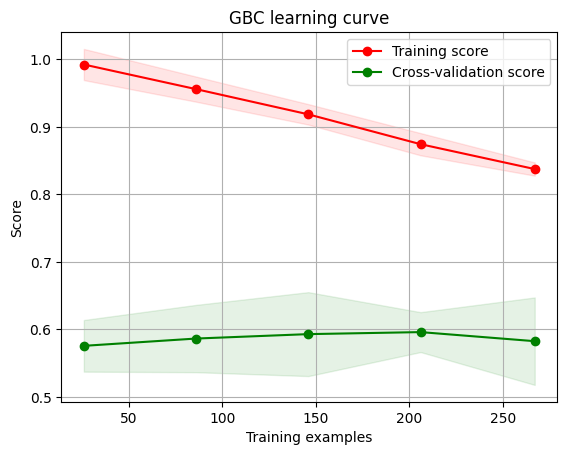

In [50]:
# Gradient boosting - Learning Curve
plot_learning_curve(estimator = gbc_best_estimator,title = "GBC learning curve", X = X_train, y = Y_train, cv = k_fold);

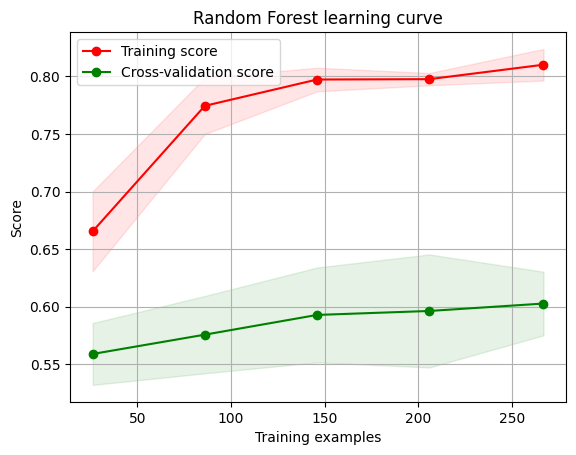

In [51]:
# Random Forest - Learning Curve
plot_learning_curve(estimator = rfc_best_estimator,title = "Random Forest learning curve", X = X_train, y = Y_train, cv = k_fold);

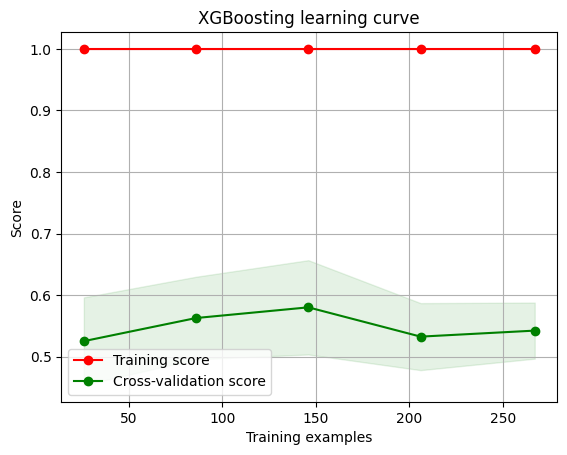

In [52]:
# XG boosting - Learning Curve
plot_learning_curve(estimator = xgb_best_estimator,title = "XGBoosting learning curve", X = X_train, y = Y_train, cv = k_fold);

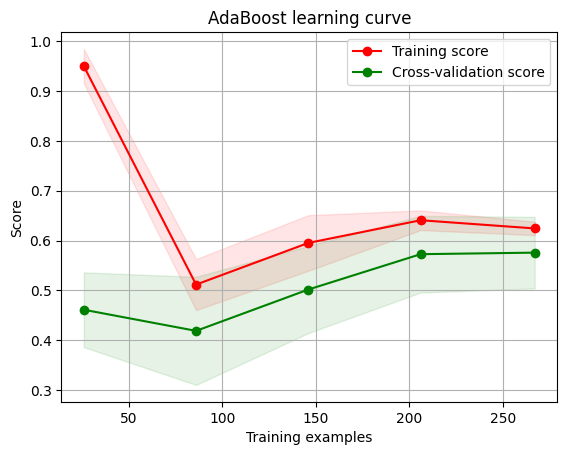

In [53]:
# Adaboost - Learning Curve
plot_learning_curve(estimator = ada_best_estimator,title = "AdaBoost learning curve", X = X_train, y = Y_train, cv = k_fold);

### Use VotingClassifier of sklearn to create an ensemble learner that utilizes the top estimators you found above. Set the voting parameter to 'soft'. Use cross_val_score to calculate its score and print out its mean and std values.

In [54]:
from sklearn.ensemble import VotingClassifier

VotingPredictor = VotingClassifier(estimators =
                           [('gbc', gbc_best_estimator),
                            ('rfc', rfc_best_estimator),
                            ('xgb', xgb_best_estimator),
                            ('ada',ada_best_estimator),
                            ('sgd',SGD_classifier),
                            ('svc',SVC_linear),
                            ('log',logistic_regression)
                            ],
                           voting='hard') #'soft' parameter cannot be used since probability estimates are not available

VotingPredictor = VotingPredictor.fit(X_train, Y_train)

emsemble_scores = cross_val_score(VotingPredictor, X_train, Y_train, cv = k_fold, scoring = scoring_parameter)


In [55]:
print("emsemble: ")
print("- mean(): " , emsemble_scores.mean())
print("- std(): " , emsemble_scores.std())

emsemble: 
- mean():  0.6026436781609196
- std():  0.0582205182804479
